In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import sys
import os

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

## 1. Read in the Data and Initial EDA

In [2]:
# Reading in the data
df = pd.read_csv('~/Desktop/cs209a-FinalProject/Harvard_G1/data/Merged_Fundamentals_and_Polls/Remastered_df_10pred.csv')
df = df.drop(['Unnamed: 0'], axis = 1)

In [3]:
display(df.head())

,popular_vote_percentage,NAP,payroll,stock,rdi,election,national_polls,gdp,state_election,Democrat_Republican
0,49.55,0.825641,0.234242,-9.718823,-1.423503,0.031317,1.083528,-0.089281,0.0,1
1,45.07,0.825641,0.234242,-9.718823,-1.423503,0.031317,0.377789,-0.089281,0.0,0
2,55.18,-0.310126,0.261147,-1.243207,9.327366,0.115117,-0.339976,0.243113,-1.0,0
3,44.33,-0.310126,0.261147,-1.243207,9.327366,0.115117,0.145107,0.243113,-1.0,1
4,57.37,0.277996,0.160302,-16.387651,6.012349,0.055845,0.396180,0.158822,1.0,0


In [5]:
display(df.describe())

,popular_vote_percentage,NAP,payroll,stock,rdi,election,national_polls,gdp,state_election,Democrat_Republican
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,47.888947,0.156816,0.080603,-6.943878,0.910273,0.033590,0.267359,0.093756,0.263158,0.500000
std,5.931859,0.292451,0.224088,14.691477,5.330156,0.053306,0.411531,0.065983,0.920758,0.506712
min,37.450000,-0.438399,-0.810255,-47.703968,-9.395652,-0.112869,-0.547339,-0.089281,-1.000000,0.000000
25%,43.647500,-0.023570,0.081262,-13.423767,-1.534151,0.031709,0.118346,0.066916,-1.000000,0.000000
50%,48.100000,0.160119,0.126141,-6.608670,0.577778,0.044007,0.185341,0.092272,1.000000,0.500000
75%,50.745000,0.290678,0.171749,-0.665031,3.717991,0.061724,0.333929,0.137343,1.000000,1.000000
max,61.050000,0.825641,0.261147,27.750394,13.389655,0.115117,1.700435,0.243113,1.000000,1.000000


The only two features that are not engineered in this DataFrame are **popular_vote_percentage** and **Democrat_Republican**.
- **popular_vote_percentage** - Shows the percentage of popular votes each presidentail candidate (Democrate or Republican) has won since 1948. As we observe from the data above, all the values seem reasonable, with $min = 37.45\%$ and $max = 61.05\%$. One thing worth poinitng out is that the mean of the **popular_vote_percentage** feature is not $\mu = 50\%$. This might seem confusing at first glance, but although the US political system is a two-party system, at each elections, there are some third-party or independent candidates that win some (usually) negligible vote percentage.
- **Democrat_Republican** - Shows if a presidential candidate is Democrat or Republican. As we expect, this feature is balanced, as exactly $50\%$ of the candidates are Democrats and the other $50\%$ are Republicans.


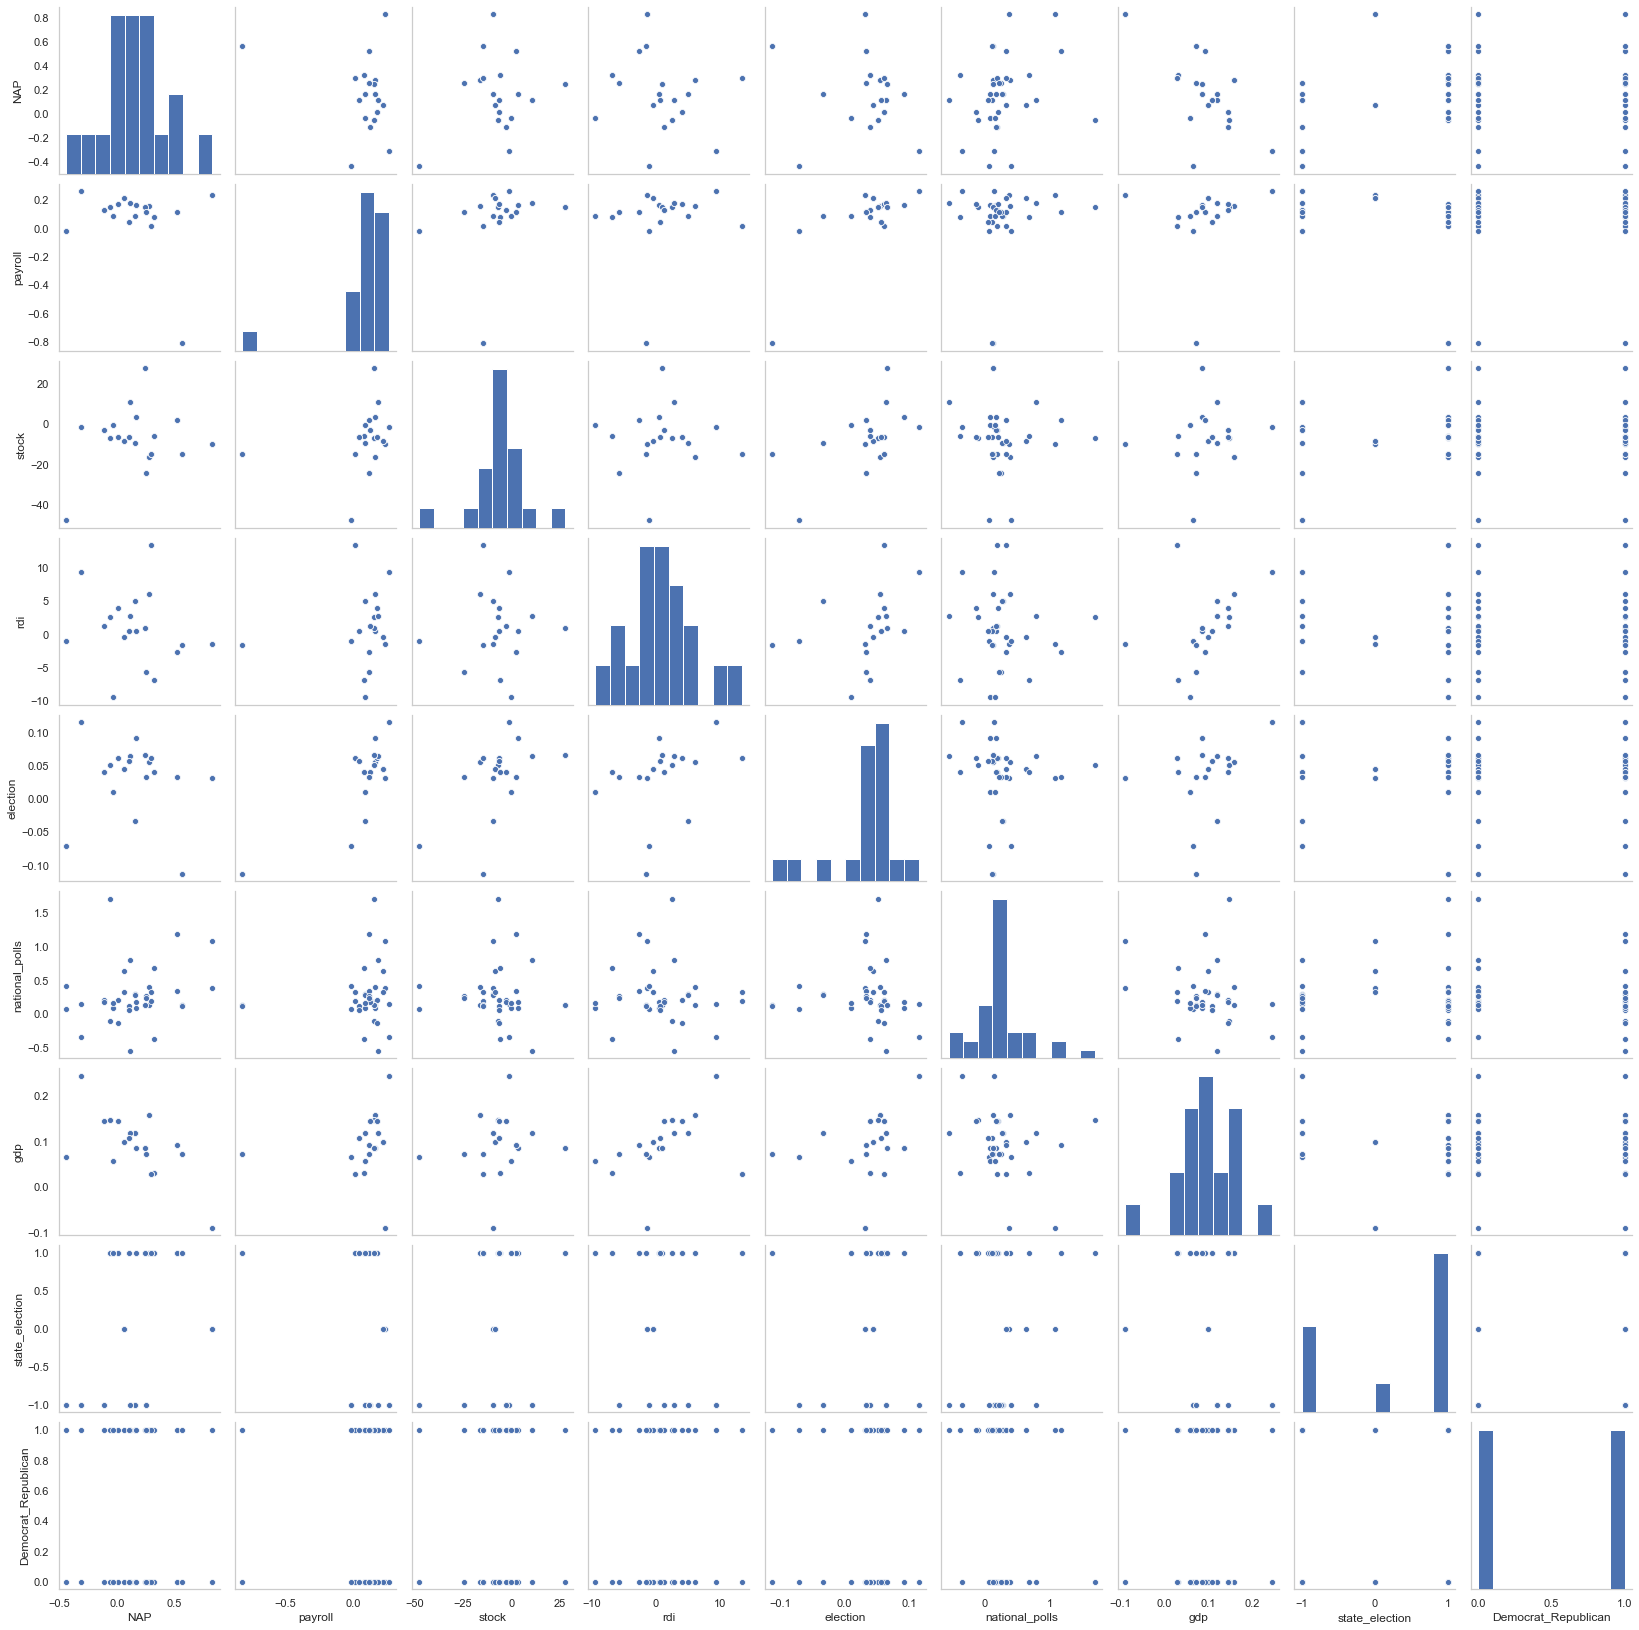

In [8]:
# Making a features pair-plot to investigate correlations between features
df_pair_plot = df.drop(['popular_vote_percentage'], axis = 1)

sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df_pair_plot)

In [9]:
# Feature correlation matrix
correlation_df = pd.DataFrame(df_pair_plot.corr())
display(correlation_df)

,NAP,payroll,stock,rdi,election,national_polls,gdp,state_election,Democrat_Republican
NAP,1.000000,-0.260702,0.208599,-0.175240,-0.118891,0.245562,-0.634079,0.396063,0.000000
payroll,-0.260702,1.000000,0.260686,0.144824,0.764232,0.094932,0.154063,-0.217054,0.000000
stock,0.208599,0.260686,1.000000,0.025136,0.534316,-0.062951,0.159207,0.282587,0.000000
rdi,-0.175240,0.144824,0.025136,1.000000,0.338385,-0.082922,0.418721,-0.096106,0.000000
election,-0.118891,0.764232,0.534316,0.338385,1.000000,-0.055610,0.310715,0.109366,0.000000
national_polls,0.245562,0.094932,-0.062951,-0.082922,-0.055610,1.000000,-0.224071,0.079351,-0.131672
gdp,-0.634079,0.154063,0.159207,0.418721,0.310715,-0.224071,1.000000,-0.197311,0.000000
state_election,0.396063,-0.217054,0.282587,-0.096106,0.109366,0.079351,-0.197311,1.000000,0.000000
Democrat_Republican,0.000000,0.000000,0.000000,0.000000,0.000000,-0.131672,0.000000,0.000000,1.000000


The pair-plot above does not display any evident correlation between features. This might seem like a good thing at first glance but actually is rather worrisome, as it might mean that our data is not expessive enough for the problem at hand. In adition we elaborate on some instances where strong features correlation was expected by did not occur:
- Weak correlation between **NAP - natinal approval rating** and **national_polls - results from national polls**. A strogner correlation between these two features was expected as the national approval rating logically seems like a direct indicator of president's results in the national polls.
- Rather strong negative correlation between **NAP - national approval rating** and **gdp - gross domestic product** $(-0.634)$. This observation is also rather surprising as it seems like in the years with lower **gdp** president's had higher **NAP**.
- Negative correlation between **NAP - natinal approval rating** and **payroll**. This one seems pretty self explanatory, in years with higher **payroll** president's **NAP** seems to have been lower.

Now we are going to explore the distribution of the variables in the DataFrame. The intent is to look for potential outliers.

Note, for this part we exclude the **Democrat_Republican** feature, as it has only two possible values, and we already know its distribution.

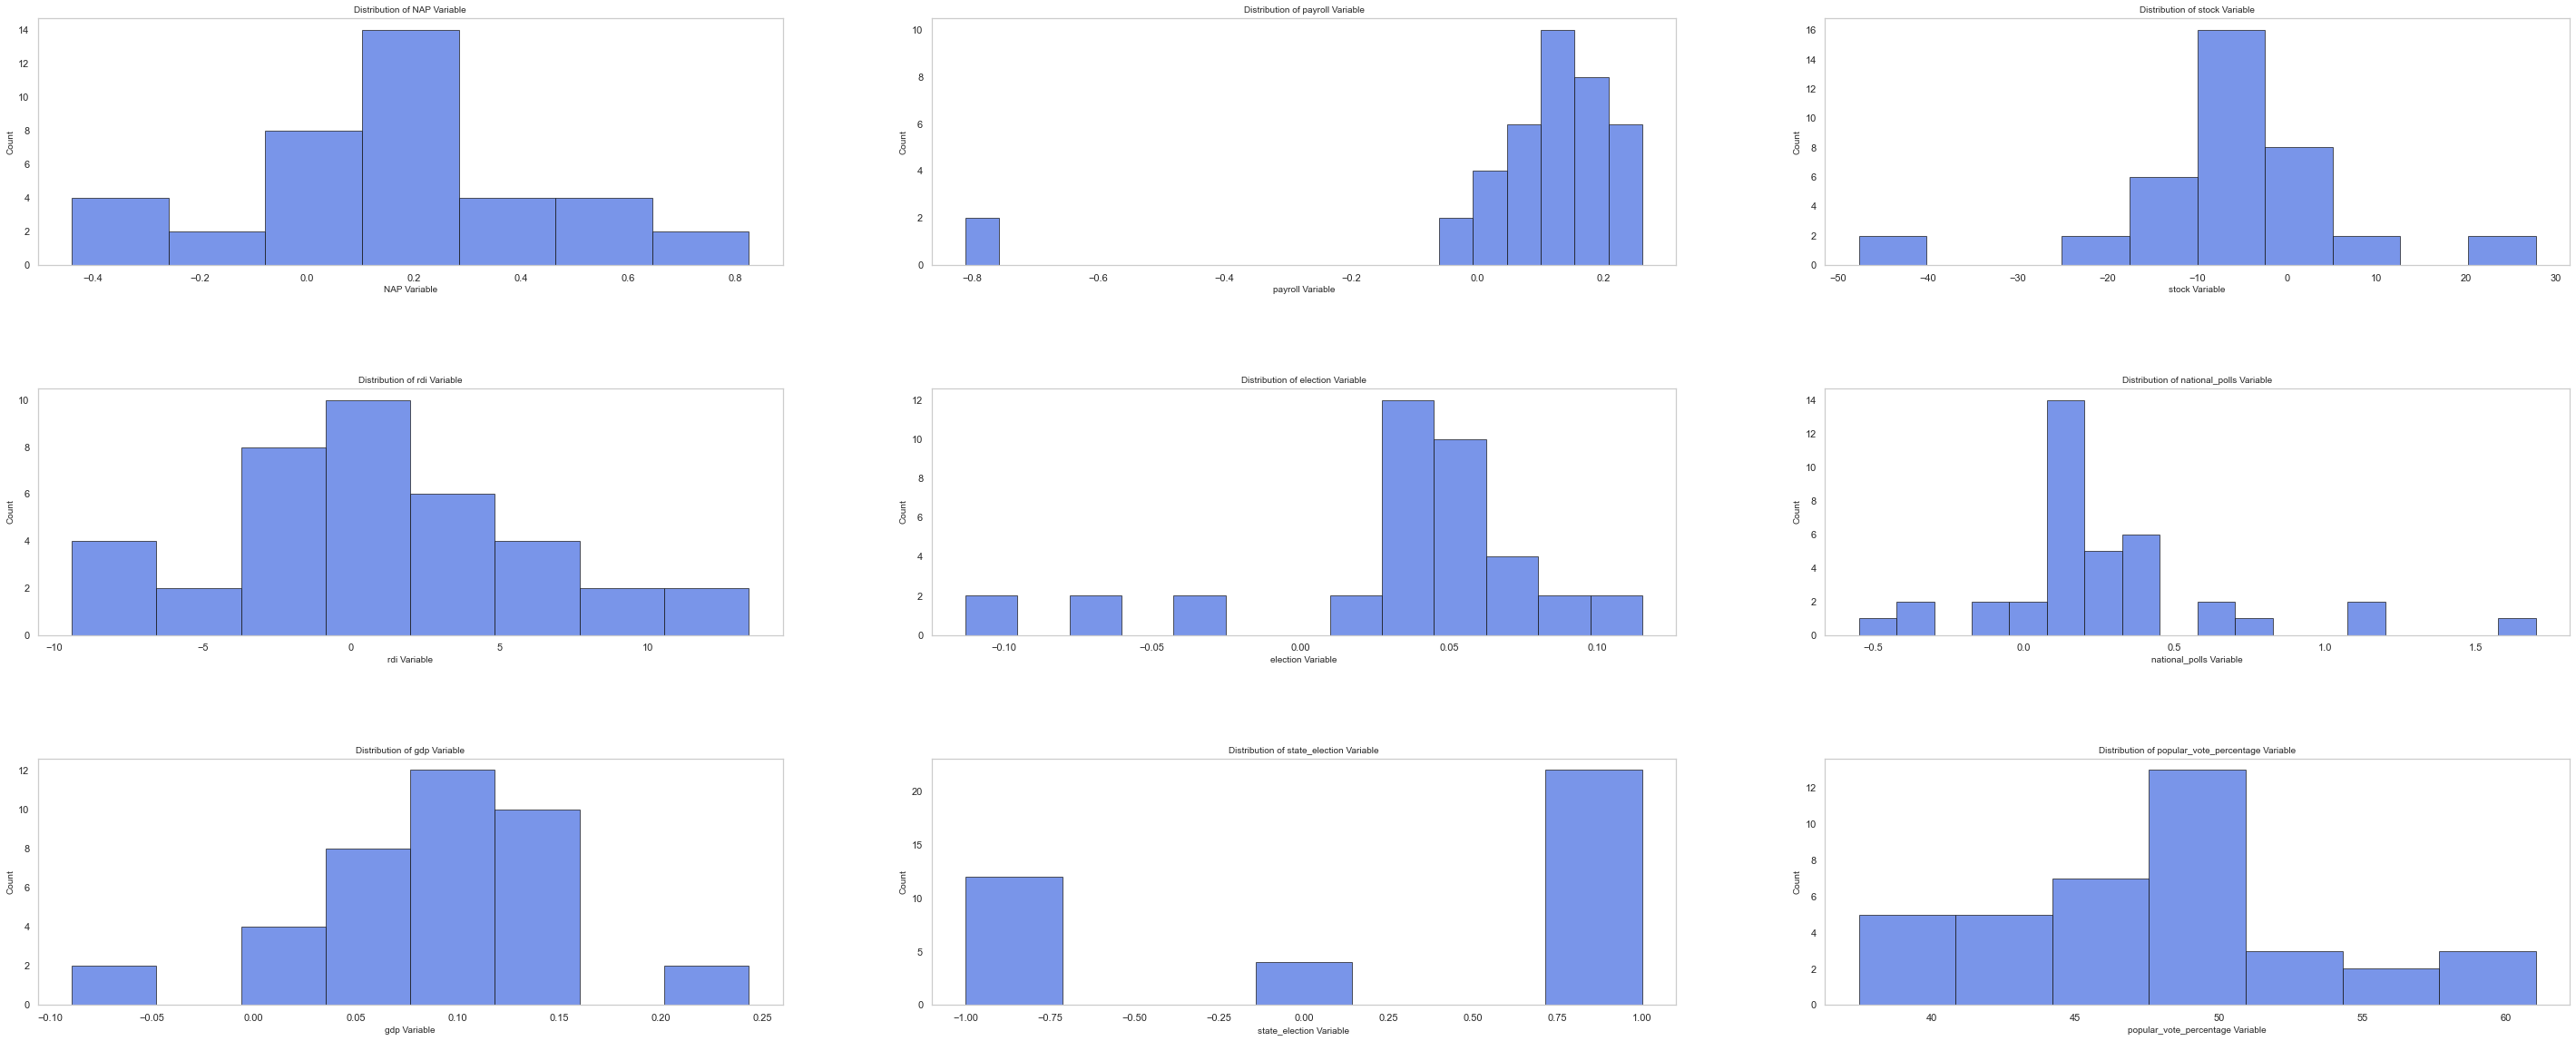

In [153]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(50, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

variables = ['NAP', 'payroll', 'stock', 'rdi', 'election', 'national_polls', 'gdp', 'state_election', 'popular_vote_percentage']

# Plot histograms
for i, variable in enumerate(variables):
    axs[i].hist(df[variable], alpha=0.7, color='royalblue', bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + variable + " Variable", fontsize=fontsize)
    axs[i].set_xlabel(variable + " Variable", fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)

All of the variables, except for **payroll** seem pretty reasonable, with a nice spread of the values. However, we do observe something weird in the **payroll** variable. There seems to be two "very" negative $-0.81$ observations, where all the other **payroll** observations are either positive or "slightly" negative. Let's explore further to see if these values outliers, or they have appeared due to some logical sequence of factors.

In [11]:
df.loc[(df['payroll']<=-0.8)]

,popular_vote_percentage,NAP,payroll,stock,rdi,election,national_polls,gdp,state_election,Democrat_Republican
36,47.4,0.55969,-0.810255,-14.658748,-1.571033,-0.112869,0.138836,0.071533,1.0,0
37,50.8,0.55969,-0.810255,-14.658748,-1.571033,-0.112869,0.116536,0.071533,1.0,1


From the data above, we observe that these two observation are from the 2020 elections. These values seems reasonable as there was an evident decline in the **payroll** as a result of the Covid-19 crisis. Therefore, we conclude that these values are not outliers and we continue further with our EDA.
Although it would be worth keeping this information in mind as the value of the **payroll** variable for the 2020 elections might highly influence our prediction of the *popular vote*.

## 2. Bootstrapped LassoCV to Assess Feature Importance

In [12]:
# Splitting into training and testing sets
X = df.drop(['popular_vote_percentage'], axis=1)
Y = df['popular_vote_percentage']
X_train = X.drop([36,37]).values
y_train = Y.drop([36,37]).values
X_test = X.iloc[[36,37]].values
y_test = Y.iloc[[36,37]].values

In [14]:
# Standardizing the features
X_1 = df.drop(['popular_vote_percentage', 'Democrat_Republican', 'state_election'], axis=1)
scaler = StandardScaler()
scaler.fit(X_1)
x_2 = scaler.transform(X_1)
X_2 = pd.DataFrame(x_2, columns = ['NAP', 'payroll','stock','rdi','election','national_polls','gdp'])
X_2['Democrat_Republican'] = df['Democrat_Republican']
X_2['state_election'] = df['state_election']
X_train1 = X_2.drop([36,37]).values
X_test1 = X_2.iloc[[36,37]].values
display(X_2)

,NAP,payroll,stock,rdi,election,national_polls,gdp,Democrat_Republican,state_election
0,2.317666,0.694822,-0.191417,-0.443721,-0.043218,2.009872,-2.811254,1,0.0
1,2.317666,0.694822,-0.191417,-0.443721,-0.043218,0.271941,-2.811254,0,0.0
2,-1.618086,0.816498,0.393234,1.600343,1.549956,-1.495606,2.293957,0,-1.0
3,-1.618086,0.816498,0.393234,1.600343,1.549956,-0.301056,2.293957,1,-1.0
4,0.419923,0.360434,-0.651435,0.970059,0.423092,0.317229,0.999344,0,1.0
5,0.419923,0.360434,-0.651435,0.970059,0.423092,-0.326338,0.999344,1,1.0
6,0.011446,0.036944,-0.169566,0.769470,-1.287107,0.063623,0.379243,1,-1.0
7,0.011446,0.036944,-0.169566,0.769470,-1.287107,0.013565,0.379243,0,-1.0
8,-0.744231,0.323772,-0.014344,0.312956,0.338592,-0.900030,0.806024,1,1.0
9,-0.744231,0.323772,-0.014344,0.312956,0.338592,3.529049,0.806024,0,1.0


In [15]:
X_2_y = X_2.copy()
X_2_y['popular_vote_percentage'] = df['popular_vote_percentage']
X_2_y = X_2_y.drop([36,37])

In [17]:
# Function to generate bootstrapped DataFrames
def bootstrap(df):
    selectionIndex = np.random.randint(len(df), size = len(df))
    new_df = df.iloc[selectionIndex]
    return new_df

In [22]:
# Bootstrapped LassoCV
n_bootstraps = 100
coefs = []
intercepts = []
for n in range(n_bootstraps):
    df_new = bootstrap(X_2_y)
    #display(df_new)
    X_train_bootstrap = df_new.drop(['popular_vote_percentage'], axis = 1).values
    y_train_bootstrap = df_new['popular_vote_percentage'].values
    lassoCV = LassoCV(fit_intercept = True, cv = 5).fit(X_train_bootstrap, y_train_bootstrap)
    coefs.append(lassoCV.coef_)
    intercepts.append(lassoCV.intercept_)

In [23]:
# Re-formatting the coefficients lists for plotting 
coef1 = []
coef2 = []
coef3 = []
coef4 = []
coef5 = []
coef6 = []
coef7 = []
coef8 = []
coef9 = []
for coef in coefs:
    if float(coef[0]) >= 0.1:
        coef1.append(coef[0])
    else:
        coef1.append(0)
    if coef[1] >= 0.1:
        coef2.append(coef[1])
    else:
        coef2.append(0)
    if coef[2] >= 0.1:
        coef3.append(coef[2])
    else:
        coef3.append(0)
    if coef[3] >= 0.1:
        coef4.append(coef[3])
    else:
        coef4.append(0)
    if coef[4] >= 0.1:
        coef5.append(coef[4])
    else:
        coef5.append(0)
    if coef[5] >= 0.1:
        coef6.append(coef[5])
    else:
        coef6.append(0)
    if coef[6] >= 0.1:
        coef7.append(coef[6])
    else:
        coef7.append(0)
    if coef[7] >= 0.1:
        coef8.append(coef[7])
    else:
        coef8.append(0)
    if coef[8] >= 0.1:
        coef9.append(coef[8])
    else:
        coef9.append(0)

In [24]:
coefs = pd.DataFrame((coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9), index = ['coef1', 'coef2', 'coef3', 'coef4', 'coef5', 'coef6', 'coef7', 'coef8', 'coef9'])
coefs = coefs.T

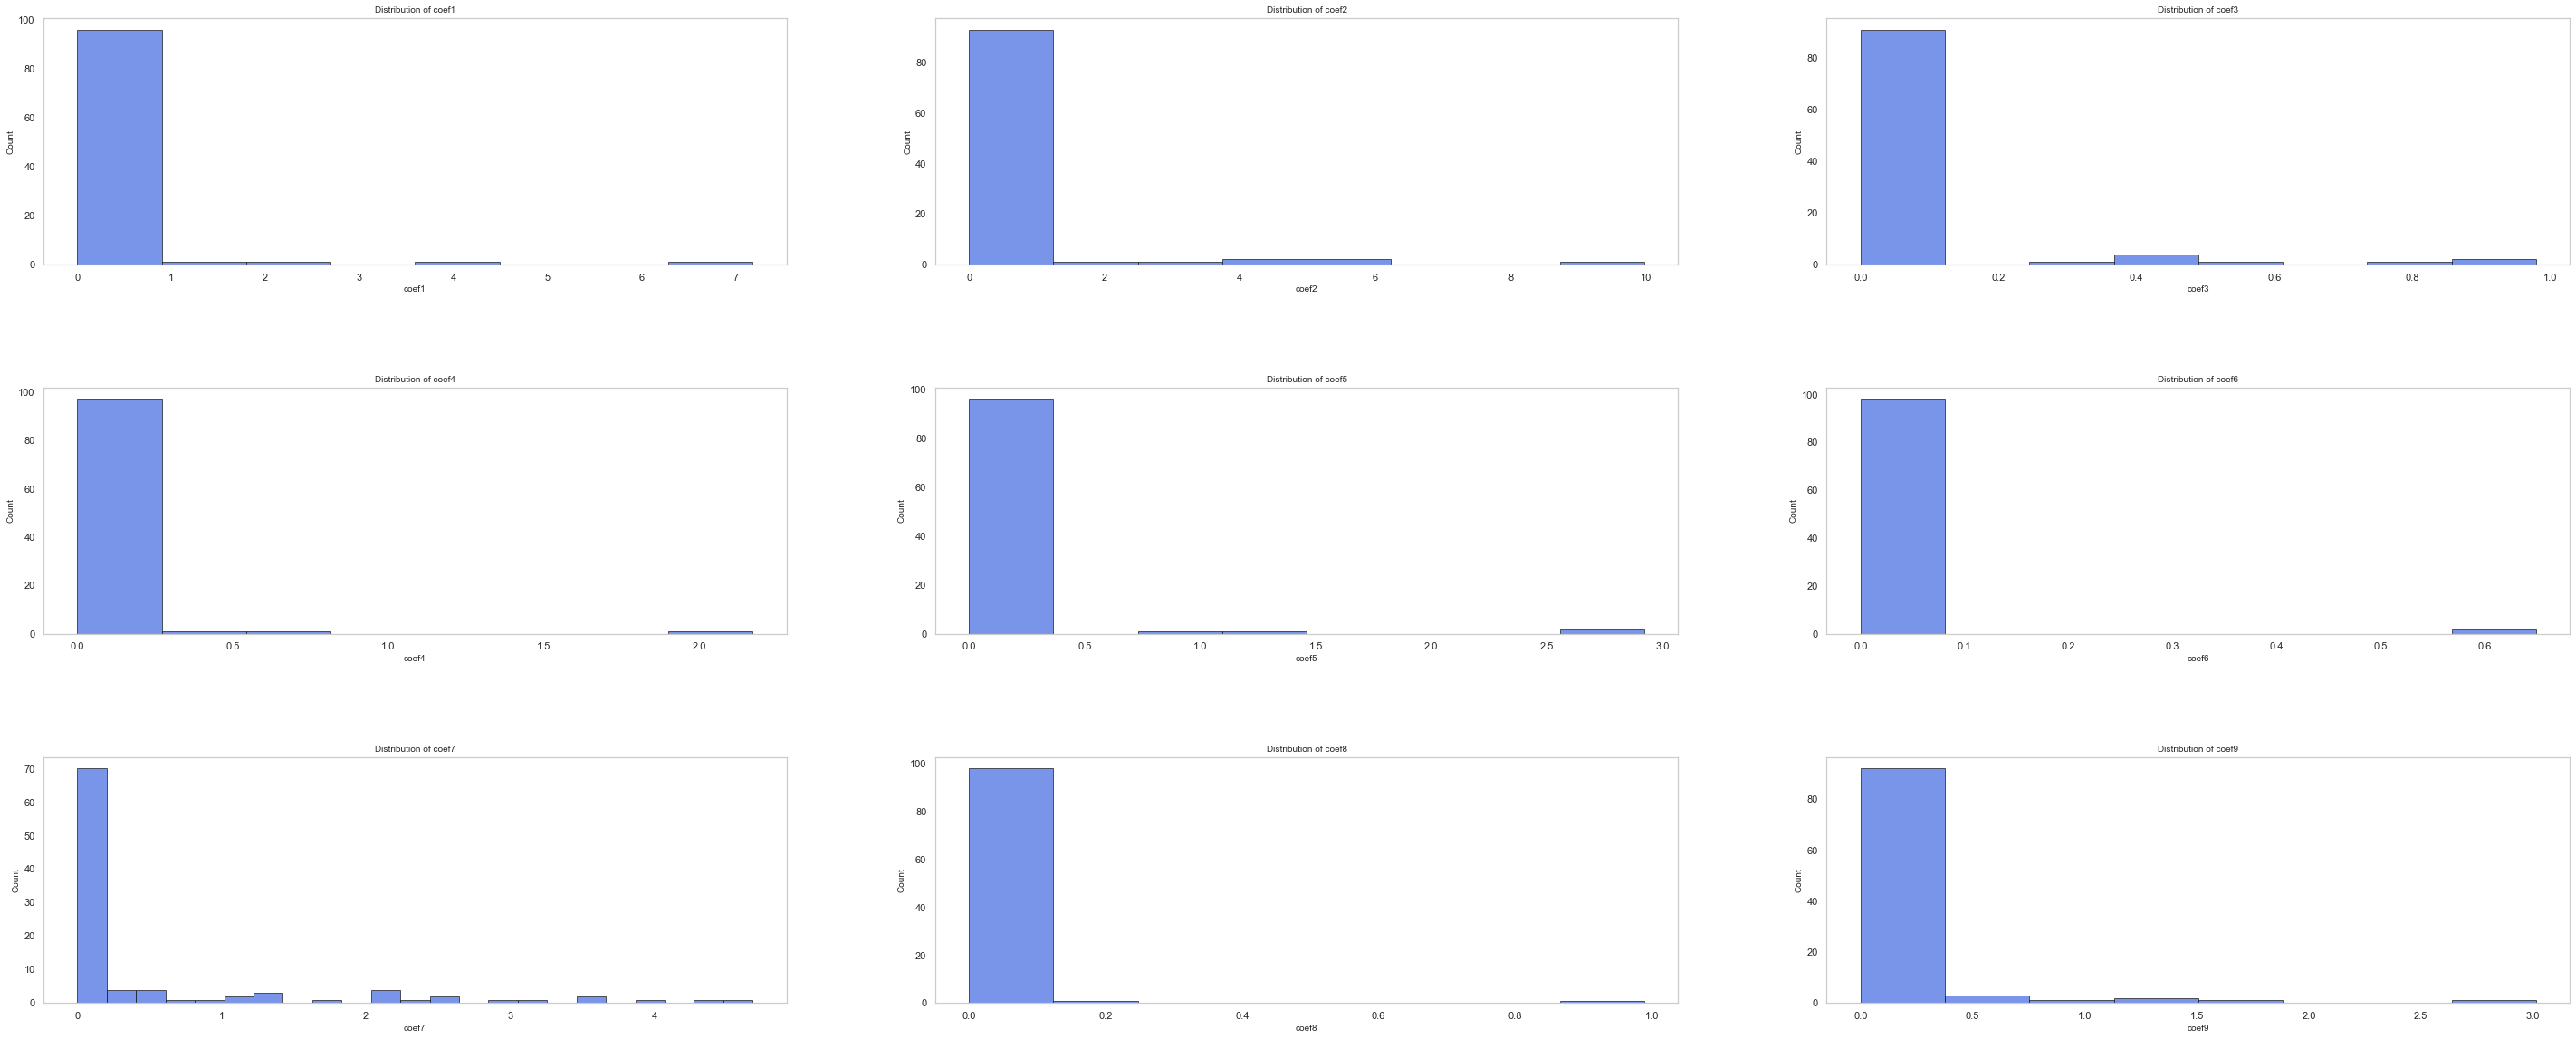

In [154]:
# Plotting histograms from bootstrapped LassoCV feature importance using 
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(50, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

variables = ['coef1', 'coef2', 'coef3', 'coef4', 'coef5', 'coef6', 'coef7', 'coef8', 'coef9']

# plot histograms
for i, variable in enumerate(variables):
    axs[i].hist(coefs[variable], alpha=0.7, color='royalblue', bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + variable, fontsize=fontsize)
    axs[i].set_xlabel(variable, fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)

**From the figure above, we observe that in most of the simulated bootstraps, the LassoCV model zeroes all feature's coefficients, i.e. the model learns that the mean prediction (intercept) is a better predictor than all of the features and therefore the features are not relevant for predicting the problem at hand.**

## 3. PCA

In [26]:
X_pca = X_2.values
pca = PCA().fit(X_pca)
X_2_PCA = pca.transform(X_pca)
print(pca.explained_variance_ratio_)
df_PCA = pd.DataFrame(X_2_PCA[:,0:6], columns = [['PCA1' , 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6']])
display(df_PCA)
X_train_pca = df_PCA.drop([36,37]).values
X_test_pca = df_PCA.iloc[[36,37]].values

[0.31236123 0.2226887  0.13932112 0.11166227 0.08443899 0.0622966
 0.03024289 0.02505786 0.01193034]


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6
0,2.316111,-2.372364,-2.244506,0.411688,-1.253257,0.479474
1,2.055887,-1.975623,-1.187277,-0.365806,-2.058805,0.337249
2,-3.810777,1.391599,0.691553,0.044185,-0.323877,0.427886
3,-3.633294,1.122014,-0.020166,0.563587,0.205593,0.517815
4,-0.696461,-0.112131,0.051944,1.287707,0.052392,-0.692427
5,-0.798868,0.048419,0.508995,0.934048,-0.352038,-0.779402
6,0.069391,1.226276,-0.301185,0.505179,-0.366204,1.177345
7,0.066180,1.228040,-0.317193,0.529383,-0.314186,1.197564
8,-1.095088,0.344331,0.854294,-0.190131,0.107043,-0.870348
9,-0.416260,-0.702062,-2.009782,1.961555,2.434797,-0.419048


When deciding on the number of principle components to be included, the main consideration was that the new DataFrame accomodates over $90\%$ of the variance contained within the original DataFrame.

## 4. Modeling

### 4.1. Linear Regression
#### - Initial DataSet

In [33]:
lreg = LinearRegression()
cv_lreg1 = cross_validate(lreg, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_lreg = np.mean(cv_lreg1['test_score'])
print(cv_lreg)


-66.84317868024239


#### - PCA DataSet

In [34]:
lreg_pca = LinearRegression()
cv_lreg1_pca = cross_validate(lreg_pca, X_train_pca, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_lreg_pca = np.mean(cv_lreg1_pca['test_score'])
print(cv_lreg_pca)

-57.03121647973162


In [35]:
results_df = pd.DataFrame({'regressor':['Linear Regression Initial Data', 'Linear Regression PCA'],
                          'Negative MSE':[cv_lreg, cv_lreg_pca]})
display(results_df)

,regressor,Negative MSE
0,Linear Regression Initial Data,-66.843179
1,Linear Regression PCA,-57.031216


### 4.2. Lasso Regression
#### - Standardized DataSet

In [52]:
lassoCV = LassoCV(fit_intercept = True, cv = 3).fit(X_train1, y_train)
alpha = lassoCV.alpha_

In [53]:
lasso = Lasso(alpha = float(alpha), fit_intercept = True)
cv_lasso1 = cross_validate(lasso, X_train1, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_lasso = np.mean(cv_lasso1['test_score'])
print(cv_lasso)

-36.46044117310111


#### - PCA DataSet

In [54]:
lassoCV_pca = LassoCV(fit_intercept = True, cv = 3).fit(X_train_pca, y_train)
alpha_pca = lassoCV_pca.alpha_

In [55]:
lasso_pca = Lasso(alpha = float(alpha_pca), fit_intercept = True)
cv_lasso1_pca = cross_validate(lasso_pca, X_train_pca, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_lasso_pca = np.mean(cv_lasso1_pca['test_score'])
print(cv_lasso_pca)

-36.12287614656399


In [56]:
results_df = pd.DataFrame({'regressor':['Linear Regression Initial Data', 'Linear Regression PCA', 'Lasso Standardized DataSet', 'Lasso PCA'],
                          'Negative MSE':[cv_lreg, cv_lreg_pca, cv_lasso, cv_lasso_pca]})
display(results_df)

,regressor,Negative MSE
0,Linear Regression Initial Data,-66.843179
1,Linear Regression PCA,-57.031216
2,Lasso Standardized DataSet,-36.460441
3,Lasso PCA,-36.122876


### 4.3. kNN
#### - Standardized DataSet

In [75]:
n = np.linspace(1,20,20)
mse_knn11 = []
mse_knn1 = []

for ni in n:
    knn = KNeighborsRegressor(n_neighbors=int(ni))
    mse_knn11 = cross_validate(knn, X_train1, y_train, cv = 3, scoring = 'neg_mean_squared_error')
    mse_knn1.append(np.mean(mse_knn11['test_score']))

print(f"NN with lowest MSE: {np.max(mse_knn1)} using n: {n[np.argmax(mse_knn1)]}")

NN with lowest MSE: -35.58701679166666 using n: 20.0


In [77]:
knn = KNeighborsRegressor(n_neighbors=20)
cv_knn1 = cross_validate(knn, X_train1, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_knn = np.mean(cv_knn1['test_score'])
print(cv_knn)

-35.58701679166666


#### - PCA DataSet

In [85]:
n = np.linspace(1,20,20)
mse_knn_pca = []
mse_knn1_pca = []

for ni in n:
    knn_pca = KNeighborsRegressor(n_neighbors=int(ni))
    mse_knn11_pca = cross_validate(knn_pca, X_train_pca, y_train, cv = 3, scoring = 'neg_mean_squared_error')
    mse_knn1_pca.append(np.mean(mse_knn11_pca['test_score']))

print(f"NN with lowest MSE: {np.max(mse_knn1_pca)} using n: {n[np.argmax(mse_knn1_pca)]}")

NN with lowest MSE: -36.098865368055556 using n: 20.0


In [86]:
knn_pca = KNeighborsRegressor(n_neighbors=20)
cv_knn1_pca = cross_validate(knn_pca, X_train_pca, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_knn_pca = np.mean(cv_knn1_pca['test_score'])
print(cv_knn_pca)

-36.098865368055556


In [87]:
results_df = pd.DataFrame({'regressor':['Linear Regression Initial Data', 'Linear Regression PCA', 'Lasso Standardized DataSet', 'Lasso PCA', 'kNN Standardized DataSet', 'kNN PCA'],
                          'Negative MSE':[cv_lreg, cv_lreg_pca, cv_lasso, cv_lasso_pca, cv_knn, cv_knn_pca]})
display(results_df)

,regressor,Negative MSE
0,Linear Regression Initial Data,-66.843179
1,Linear Regression PCA,-57.031216
2,Lasso Standardized DataSet,-36.460441
3,Lasso PCA,-36.122876
4,kNN Standardized DataSet,-35.587017
5,kNN PCA,-36.098865


### 4.4. Decision Tree
#### - Initial DataSet

In [108]:
max_depths = np.linspace(1,20,20)
mse_dtree = []

for max_depth in max_depths:
    dtree =  DecisionTreeRegressor(max_depth = max_depth)
    mse_dtree1 = cross_validate(dtree, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error')
    mse_dtree.append(np.mean(mse_dtree1['test_score']))

print(f"The lowest MSE: {np.max(mse_dtree)}, with max_tree depth: {max_depths[np.argmax(mse_dtree)]}")

The lowest MSE: -55.775957881848775, with max_tree depth: 1.0


In [109]:
dtree =  DecisionTreeRegressor(max_depth = 1)
cv_dtree1 = cross_validate(dtree, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_dtree = np.mean(cv_dtree1['test_score'])
print(cv_dtree)

-55.77595788184876


#### - PCA DataSet

In [110]:
max_depths = np.linspace(1,20,20)
mse_dtree_pca = []

for max_depth in max_depths:
    dtree_pca =  DecisionTreeRegressor(max_depth = max_depth)
    mse_dtree1_pca = cross_validate(dtree_pca, X_train_pca, y_train, cv = 3, scoring = 'neg_mean_squared_error')
    mse_dtree_pca.append(np.mean(mse_dtree1_pca['test_score']))

print(f"The lowest MSE: {np.max(mse_dtree_pca)}, with max_tree depth: {max_depths[np.argmax(mse_dtree_pca)]}")

The lowest MSE: -37.9396293410748, with max_tree depth: 1.0


In [111]:
dtree_pca =  DecisionTreeRegressor(max_depth = 1)
cv_dtree1_pca = cross_validate(dtree_pca, X_train_pca, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_dtree_pca = np.mean(cv_dtree1_pca['test_score'])
print(cv_dtree_pca)

-37.9396293410748


In [112]:
results_df = pd.DataFrame({'regressor':['Linear Regression Initial Data', 'Linear Regression PCA', 'Lasso Standardized DataSet', 'Lasso PCA', 'kNN Standardized DataSet', 'kNN PCA', 'Decision Tree Initial Data', 'Decision Tree PCA'],
                          'Negative MSE':[cv_lreg, cv_lreg_pca, cv_lasso, cv_lasso_pca, cv_knn, cv_knn_pca, cv_dtree, cv_dtree_pca]})
display(results_df)

,regressor,Negative MSE
0,Linear Regression Initial Data,-66.843179
1,Linear Regression PCA,-57.031216
2,Lasso Standardized DataSet,-36.460441
3,Lasso PCA,-36.122876
4,kNN Standardized DataSet,-35.587017
5,kNN PCA,-36.098865
6,Decision Tree Initial Data,-55.775958
7,Decision Tree PCA,-37.939629


### 4.5. Random Forrest
#### - Initial DataSet

In [120]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, 20)]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

# Create a based model
rf = RandomForestRegressor(random_state = 42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

grid_search.best_params_


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.5min finished


{'max_depth': 1, 'n_estimators': 800}

In [125]:
rf = RandomForestRegressor(n_estimators = 800, max_depth = 1, random_state = 42)
cv_rf1 = cross_validate(rf, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_rf = np.mean(cv_rf1['test_score'])
print(cv_rf)

-44.29615891084703


#### - PCA DataSet

In [126]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, 20)]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

# Create a based model
rf = RandomForestRegressor(random_state = 42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 2)
grid_search.fit(X_train_pca, y_train)

grid_search.best_params_


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.6min finished


{'max_depth': 1, 'n_estimators': 900}

In [127]:
rf_pca = RandomForestRegressor(n_estimators = 900, max_depth = 1, random_state = 42)
cv_rf1_pca = cross_validate(rf_pca, X_train_pca, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_rf_pca = np.mean(cv_rf1_pca['test_score'])
print(cv_rf_pca)

-39.74266473515445


In [128]:
results_df = pd.DataFrame({'regressor':['Linear Regression Initial Data', 'Linear Regression PCA', 'Lasso Standardized DataSet', 'Lasso PCA', 'kNN Standardized DataSet', 'kNN PCA', 'Decision Tree Initial Data', 'Decision Tree PCA','Random Forest Initial DataSet', 'Random Forest PCA'],
                          'Negative MSE':[cv_lreg, cv_lreg_pca, cv_lasso, cv_lasso_pca, cv_knn, cv_knn_pca, cv_dtree, cv_dtree_pca, cv_rf, cv_rf_pca]})
display(results_df)

,regressor,Negative MSE
0,Linear Regression Initial Data,-66.843179
1,Linear Regression PCA,-57.031216
2,Lasso Standardized DataSet,-36.460441
3,Lasso PCA,-36.122876
4,kNN Standardized DataSet,-35.587017
5,kNN PCA,-36.098865
6,Decision Tree Initial Data,-55.775958
7,Decision Tree PCA,-37.939629
8,Random Forest Initial DataSet,-44.296159
9,Random Forest PCA,-39.742665


### 4.6. Boosting
#### - Initial DataSet

In [130]:
depths = np.linspace(1,10,10)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 11, stop = 501, num = 20)]
# Learning Rate
learning_rate = [1e-3,1e-2,1e-1,1,10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate}

scores = []
params = []
for depth in depths:
    # Create a based model
    ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = depth), random_state = 0)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = ada, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    params.append(grid_search.best_params_)
    print(grid_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    7.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 0.1, 'n_estimators': 88}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.8s finished


{'learning_rate': 0.01, 'n_estimators': 294}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 1, 'n_estimators': 11}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 0.01, 'n_estimators': 139}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 0.01, 'n_estimators': 114}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 0.1, 'n_estimators': 62}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 1, 'n_estimators': 11}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 1, 'n_estimators': 11}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 1, 'n_estimators': 11}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   11.4s


{'learning_rate': 1, 'n_estimators': 11}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   18.5s finished


In [142]:
learning_rate = 0.1
depth = 1
n_estimators = 88

ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = depth), n_estimators = n_estimators, learning_rate = learning_rate, random_state = 0)
cv_boosting1 = cross_validate(ada, X_train, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_boosting = np.mean(cv_boosting1['test_score'])
print(cv_boosting)

-41.213962407020816


#### - PCA DataSet

In [143]:
depths = np.linspace(1,7,7)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 11, stop = 501, num = 20)]
# Learning Rate
learning_rate = [1e-3,1e-2,1e-1,1,10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate}

scores = []
params = []
for depth in depths:
    # Create a based model
    ada_pca = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = depth), random_state = 0)
    # Instantiate the grid search model
    grid_search_ada = GridSearchCV(estimator = ada_pca, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')
    grid_search_ada.fit(X_train_pca, y_train)
    
    params.append(grid_search_ada.best_params_)
    print(grid_search_ada.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    9.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 0.01, 'n_estimators': 88}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.1s finished


{'learning_rate': 0.001, 'n_estimators': 320}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.2s finished


{'learning_rate': 0.001, 'n_estimators': 320}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'learning_rate': 0.1, 'n_estimators': 62}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.9s finished


{'learning_rate': 0.01, 'n_estimators': 165}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.2s finished


{'learning_rate': 0.01, 'n_estimators': 320}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   19.5s finished


{'learning_rate': 0.01, 'n_estimators': 294}


In [151]:
learning_rate = 0.01
depth = 1
n_estimators = 88

ada_pca = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = depth), n_estimators = n_estimators, learning_rate = learning_rate, random_state = 0)
cv_boosting1_pca = cross_validate(ada_pca, X_train_pca, y_train, cv = 3, scoring = 'neg_mean_squared_error')
cv_boosting_pca = np.mean(cv_boosting1_pca['test_score'])
print(cv_boosting_pca)

-37.23086646631513


In [152]:
results_df = pd.DataFrame({'regressor':['Linear Regression Initial Data', 'Linear Regression PCA', 'Lasso Standardized DataSet', 'Lasso PCA', 'kNN Standardized DataSet', 'kNN PCA', 'Decision Tree Initial Data', 'Decision Tree PCA','Random Forest Initial DataSet', 'Random Forest PCA', 'Boosting Initial DataSet', 'Boosting PCA'],
                          'Negative MSE':[cv_lreg, cv_lreg_pca, cv_lasso, cv_lasso_pca, cv_knn, cv_knn_pca, cv_dtree, cv_dtree_pca, cv_rf, cv_rf_pca, cv_boosting, cv_boosting_pca]})
display(results_df)

,regressor,Negative MSE
0,Linear Regression Initial Data,-66.843179
1,Linear Regression PCA,-57.031216
2,Lasso Standardized DataSet,-36.460441
3,Lasso PCA,-36.122876
4,kNN Standardized DataSet,-35.587017
5,kNN PCA,-36.098865
6,Decision Tree Initial Data,-55.775958
7,Decision Tree PCA,-37.939629
8,Random Forest Initial DataSet,-44.296159
9,Random Forest PCA,-39.742665
